In [1]:
from spyglass.spikesorting import CuratedSpikeSorting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spyglass.common import interval_list_contains_ind

import os
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from ms_opto_stim_protocol import OptoStimProtocol
from spyglass.common import convert_epoch_interval_name_to_position_interval_name

[2023-11-29 09:52:05,739][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2023-11-29 09:52:05,784][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


# Version Using Binned spikes

In [103]:
from spyglass.common import PositionIntervalMap
from spyglass.common import interval_list_intersect, interval_list_contains_ind

import os
import numpy as np
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from Analysis.position_analysis import get_running_intervals, filter_position_ports
from Analysis.utils import get_running_valid_intervals, autocorr2d
from ms_opto_stim_protocol import OptoStimProtocol

basic_key  = {'nwb_file_name': 'Totoro20220602_.nwb', 'sort_interval_name': '12_lineartrack'}
filter_speed = 10
filter_ports = True


interval_key  = {'nwb_file_name': 'Totoro20220602_.nwb', 'interval_list_name': basic_key['sort_interval_name']}
pos_interval_name = (PositionIntervalMap() & interval_key).fetch1('position_interval_name')
pos_key = {'nwb_file_name': basic_key['nwb_file_name'], 'interval_list_name': pos_interval_name}






In [30]:
interval_list_contains_ind(control_run_interval,t)
spike_counts[0].shape

(1, 601968)

In [104]:
PositionIntervalMap()

*nwb_file_name *interval_list position_inter
+------------+ +------------+ +------------+
aj8020230628_. 02_lineartrack pos 0 valid ti
aj8020230628_. 04_lineartrack pos 1 valid ti
aj8620230628_. 04_lineartrack pos 1 valid ti
aj8620230628_. 06_lineartrack pos 2 valid ti
arthur20220314 01_s1          pos 0 valid ti
arthur20220314 02_r1          pos 1 valid ti
arthur20220314 03_s2          pos 2 valid ti
arthur20220314 04_r2          pos 3 valid ti
arthur20220314 05_s3          pos 4 valid ti
arthur20220314 06_r3          pos 5 valid ti
arthur20220314 07_s4          pos 6 valid ti
arthur20220315 01_s1          pos 0 valid ti
   ...
 (Total: 5625)

In [16]:
from spiking_analysis_tables import BinnedSpiking

basic_key  = {'nwb_file_name': 'Totoro20220602_.nwb', 'sort_interval_name': '14_lineartrack'}
filter_speed = 10
filter_ports = True

interval_key  = {'nwb_file_name': 'Totoro20220602_.nwb', 'interval_list_name': basic_key['sort_interval_name']}
pos_interval_name = (PositionIntervalMap() & interval_key).fetch1('position_interval_name')
pos_key = {'nwb_file_name': basic_key['nwb_file_name'], 'interval_list_name': pos_interval_name}

optogenetic_run_interval, control_run_interval = get_running_valid_intervals(pos_key, filter_speed=filter_speed, filter_ports=filter_ports, seperate_optogenetics=True)
auto_corr_window = 500


# Get binned spiking data
key_list = BinnedSpiking().get_current_curation_key_list(basic_key)
spike_counts = []
times = []
for key in key_list:
    group_counts = (BinnedSpiking & key).fetch1('binned_spiking')
    if len(group_counts)>0:
        spike_counts.append(group_counts)
        times.append((BinnedSpiking & key).fetch1('time_bins'))
 
C = [[[] for _ in spike_counts],
     [[] for _ in spike_counts]] 
for cond,interval_list in enumerate([control_run_interval, optogenetic_run_interval]):
    for interval in interval_list:
        for i,(t,counts) in enumerate(zip(times,spike_counts)):
            ind = interval_list_contains_ind(np.array([interval]), t)
            if ind.size >= auto_corr_window:
                C[cond][i].append(autocorr2d(counts[:,ind].T)[:auto_corr_window])
            else:
                C[cond][i].append(np.zeros((auto_corr_window,counts.shape[0]))*np.nan)

C = [np.concatenate(c,axis=-1) for c in C]
period_ms = (OptoStimProtocol() & pos_key).fetch1('period_ms')
 
    
# t_earliest = None
# t_latest = None
# for t in times:
#     if t_earliest is None:
#         t_earliest = t 
#     if t_latest is None:
#         t_latest = t
#     if t[0]<t_earliest[0]:
#         t_earliest = t
#     if t[-1]>t_latest[-1]:
#         t_latest = t

# min_size = np.inf
# for i,(t,counts) in enumerate(zip(times,spike_counts)):
#     pad_front = np.digitize(t[0],t_earliest,right=False)-1
#     pad_end = t_latest.size-np.digitize(t[-1],t_latest,right=True)-1
#     print(pad_front,pad_end)
#     print(pad_front+pad_end+t.size)
#     spike_counts[i] = np.pad(counts,((0,0),(pad_front,pad_end)))
#     if spike_counts[i].shape[1]<min_size:
#         min_size = spike_counts[i].shape[1]
        
# spike_counts = np.concatenate([counts[:,:min_size] for counts in spike_counts],axis=0)
    
    
    
    
    
# time_rng = (np.nan,np.nan)
# for t in times:
#     time_rng = (min(time_rng[0],t[0]), max(time_rng[1],t[-1]))
# for t, counts in zip(times, spike_counts):
#     st = np.digitize(time_rng[0], t)
#     en = np.digitize(time_rng[1], t)
#     spike_counts[i] = counts[:,st:en]





NameError: name 'PositionIntervalMap' is not defined

In [91]:
C

[[], []]

/tmp/ipykernel_1606840/2140042241.py:6: RuntimeWarning: Mean of empty slice
  ax[cond].plot(t,np.nanmean(C[cond],axis=(0)),color=color,alpha=.1)


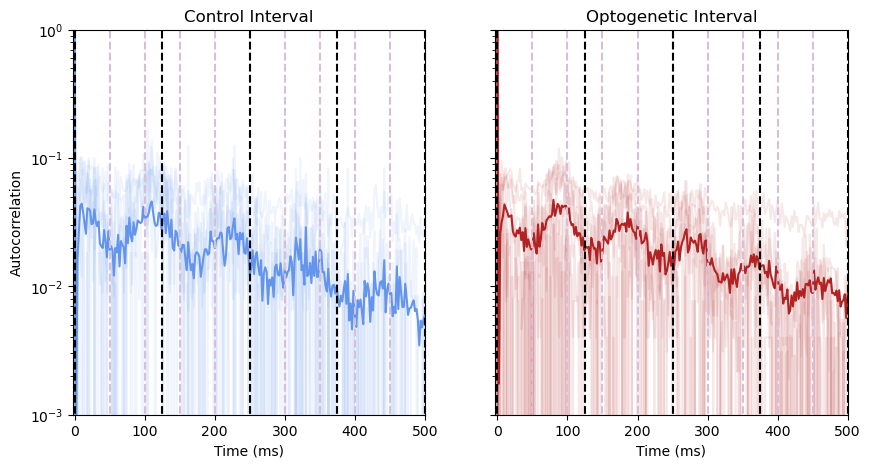

In [100]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
t = np.arange(auto_corr_window)*2
for cond, color in enumerate(['cornflowerblue','firebrick']):
    ax[cond].plot(t,np.nanmean(C[cond],axis=(0)),color=color,alpha=.1)
    ax[cond].plot(t,np.nanmean(C[cond],axis=(0,2)),color=color,alpha=1)        
ax[0].set_yscale('log')
ax[0].set_ylim([1e-3,1])
# ax[0].set_xscale('log')
ax[0].set_xlim([-3,500])

ax[0].set_ylabel('Autocorrelation')
ax[0].set_xlabel('Time (ms)')
ax[1].set_xlabel('Time (ms)')
ax[0].set_title('Control Interval')
ax[1].set_title('Optogenetic Interval')

for i in range(10):
    ax[0].vlines(x=period_ms*i,ymin=0,ymax=1,color='thistle',linestyle='--')
    ax[1].vlines(x=period_ms*i,ymin=0,ymax=1,color='thistle',linestyle='--')
    
for i in range(10):
    ax[0].vlines(x=125*i,ymin=0,ymax=1,color='k',linestyle='--')
    ax[1].vlines(x=125*i,ymin=0,ymax=1,color='k',linestyle='--')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
datasets: 4
linear_limits [28.52000000000009, 68.35000000000016]
linear_limits [34.0099999999999, 64.96000000000008]
linear_limits [33.73999999999981, 65.94999999999976]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(26, 500, 84) (59, 500, 84)
2 2
linear_limits [30.770000000000216, 68.10999999999986]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(35, 500, 39) (117, 500, 39)
2 2


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


datasets: 4
linear_limits [32.629999999999974, 66.13000000000002]
linear_limits [77.87000000000005, 42.01000000000014]
linear_limits [34.36999999999994, 65.94999999999993]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(20, 500, 55) (66, 500, 55)
2 2


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [32.35999999999995, 66.72999999999968]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(43, 500, 36) (70, 500, 36)
2 2
datasets: 2
linear_limits [34.309999999999945, 63.69999999999979]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [34.21999999999983, 62.08000000000001]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(24, 500, 27) (71, 500, 27)
2 2
datasets: 2
linear_limits [33.140000000000235, 66.30999999999997]
linear_limits [34.459999999999866, 65.53000000000009]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(27, 500, 23) (87, 500, 23)
2 2
datasets: 2
linear_limits [31.1, 65.4999999999996]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(39, 500, 26) (61, 500, 26)
2 2
linear_limits [33.499999999999986, 66.04000000000015]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(30, 500, 30) (94, 500, 30)
2 2
datasets: 2
linear_limits [34.459999999999816, 63.339999999999876]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(25, 500, 21) (63, 500, 21)
2 2
linear_limits [34.580000000000055, 68.05000000000025]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(28, 500, 20) (94, 500, 20)
2 2
datasets: 2
linear_limits [28.428666666667496, 75.81733333333331]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [19.99999999999998, 58.427333333333266]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(114, 500, 13) (299, 500, 13)
2 2
datasets: 2
linear_limits [28.961333333333876, 77.32133333333402]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [20.65799999999953, 59.99399999999976]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(31, 500, 12) (86, 500, 12)
2 2
datasets: 2
linear_limits [26.705333333334103, 77.57200000000071]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [20.00000000000007, 59.993999999999815]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(108, 500, 8) (291, 500, 8)
2 2
datasets: 2
linear_limits [27.269333333333705, 77.76000000000079]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [20.469999999999768, 59.93133333333323]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(147, 500, 16) (652, 500, 16)
2 2
datasets: 2
linear_limits [28.836000000000247, 77.94800000000023]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [20.563999999999844, 59.99399999999986]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(133, 500, 20) (229, 500, 20)
2 2
datasets: 0
datasets: 3
linear_limits [26.870000000000122, 66.94000000000058]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [118.18999999999856, 163.05999999999935]
linear_limits [28.189999999999557, 62.76999999999964]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(34, 500, 120) (84, 500, 120)
2 2
datasets: 3


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [26.509999999999962, 67.99000000000025]
linear_limits [116.30000000000028, 162.5199999999989]
linear_limits [33.049999999999784, 66.3999999999998]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(26, 500, 109) (60, 500, 109)
2 2
datasets: 3


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [25.339999999999556, 67.6599999999996]
linear_limits [117.61999999999904, 162.51999999999902]
linear_limits [32.80999999999999, 66.04000000000009]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(36, 500, 99) (125, 500, 99)
2 2


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


datasets: 3
linear_limits [29.089999999999673, 67.47999999999986]
linear_limits [115.72999999999955, 162.4599999999996]
linear_limits [32.960000000000036, 65.85999999999996]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(40, 500, 121) (64, 500, 121)
2 2
datasets: 3


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [29.720000000000006, 66.9399999999999]
linear_limits [117.19999999999924, 162.0100000000002]
linear_limits [29.11999999999979, 65.31999999999962]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(21, 500, 97) (70, 500, 97)
2 2
datasets: 3
linear_limits [30.0499999999997, 66.57999999999966]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [112.5499999999993, 157.74999999999844]
linear_limits [26.960000000000086, 67.30000000000042]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(36, 500, 86) (106, 500, 86)
2 2
datasets: 1


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [20.000000000000124, 59.931333333333896]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(322, 500, 28) (747, 500, 28)
2 2
datasets: 1


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [19.999999999999655, 59.99399999999979]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(426, 500, 36) (399, 500, 36)
2 2
datasets: 2


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [20.28199999999991, 59.99400000000034]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(15, 500, 17) (165, 500, 17)
2 2


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [20.56400000000013, 59.99399999999993]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)


(5, 500, 24) (15, 500, 24)
2 2
datasets: 1
linear_limits [20.43866666666626, 59.993999999999986]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(88, 500, 28) (86, 500, 28)
2 2
datasets: 2


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  color=color,
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:114: RuntimeWarning: Mean of empty slice
  ax[0].set_ylabel("Autocorrelation")


linear_limits [20.313333333333404, 59.99399999999986]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(0,) (434, 500, 22)
2 2


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


linear_limits [20.25066666666709, 59.99400000000037]


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/utils.py:233: RuntimeWarning: invalid value encountered in divide
  return result[:n] / result[0]


(50, 500, 42) (125, 500, 42)
2 2


/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:99: RuntimeWarning: Mean of empty slice
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
/home/sambray/Documents/MS_analysis_samsplaying/Analysis/spiking_autocorrelation.py:100: RuntimeWarning: Mean of empty slice
  t = np.arange(auto_corr_window) * 2


ValueError: zero-dimensional arrays cannot be concatenated

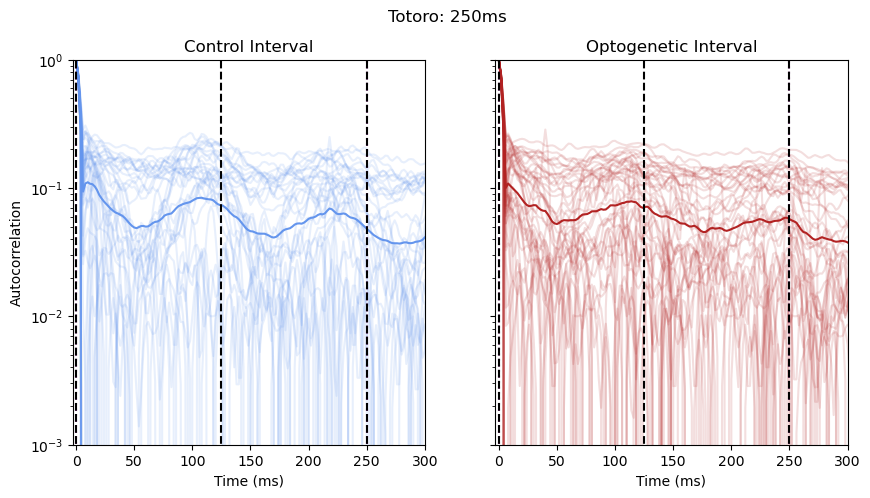

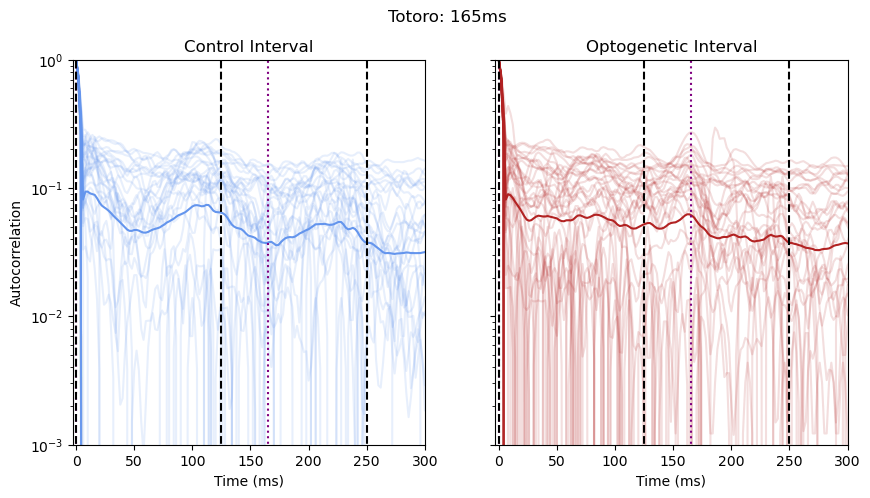

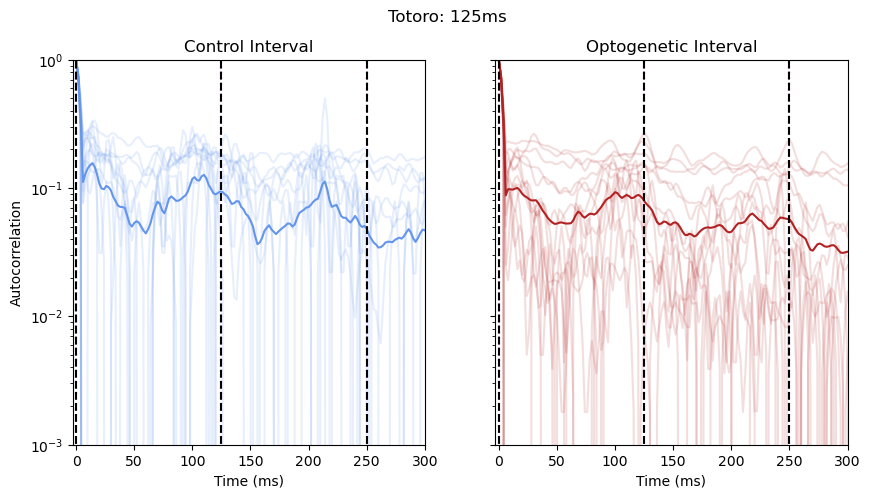

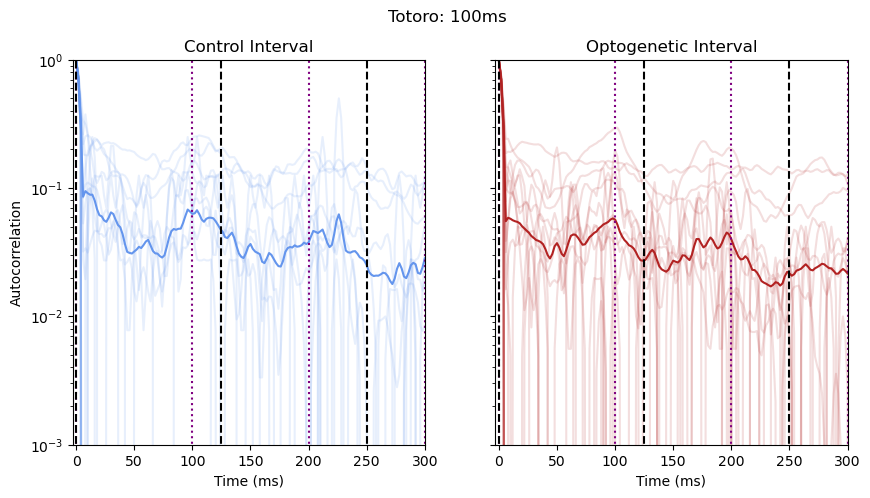

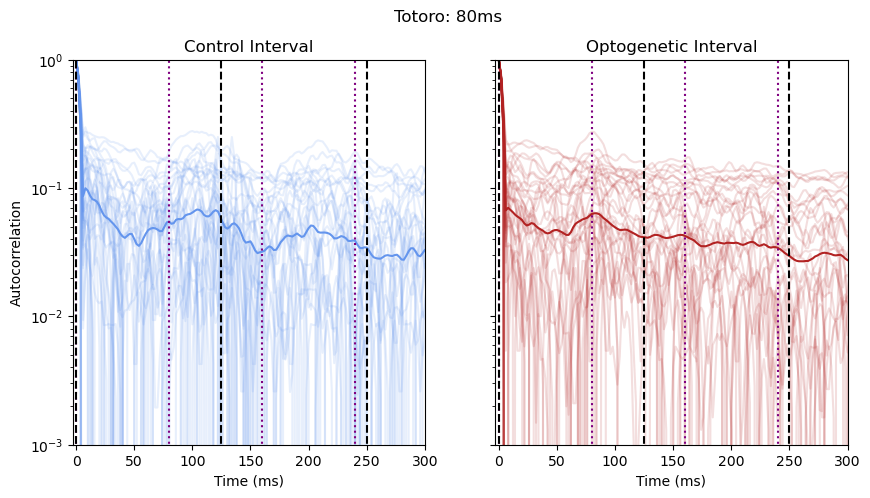

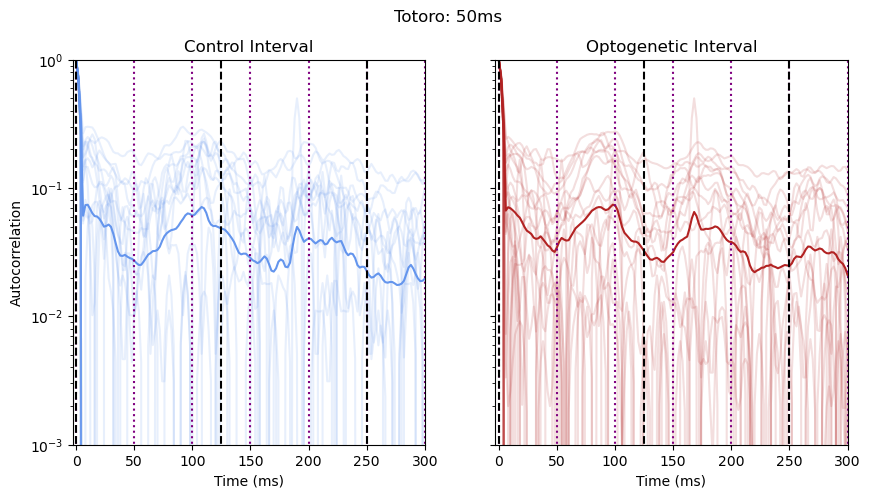

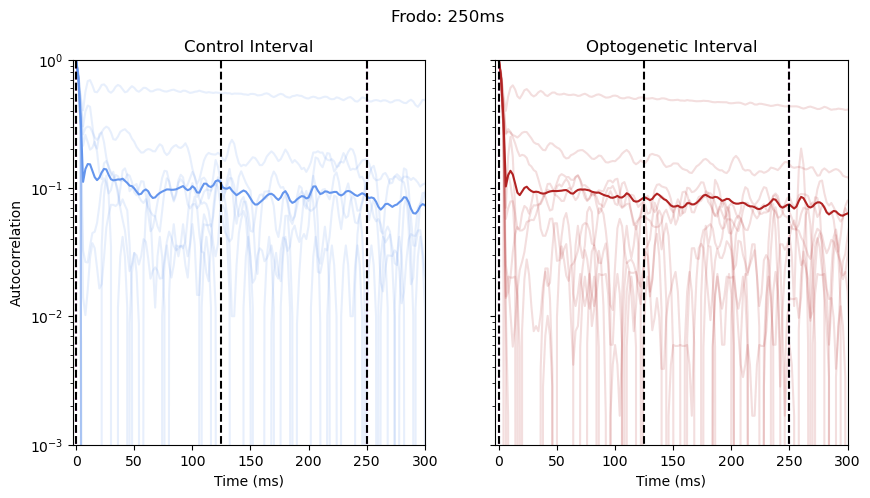

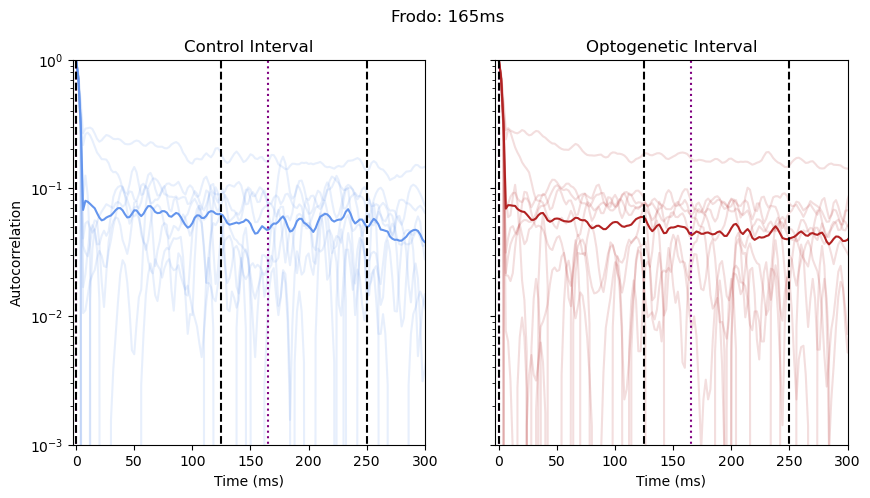

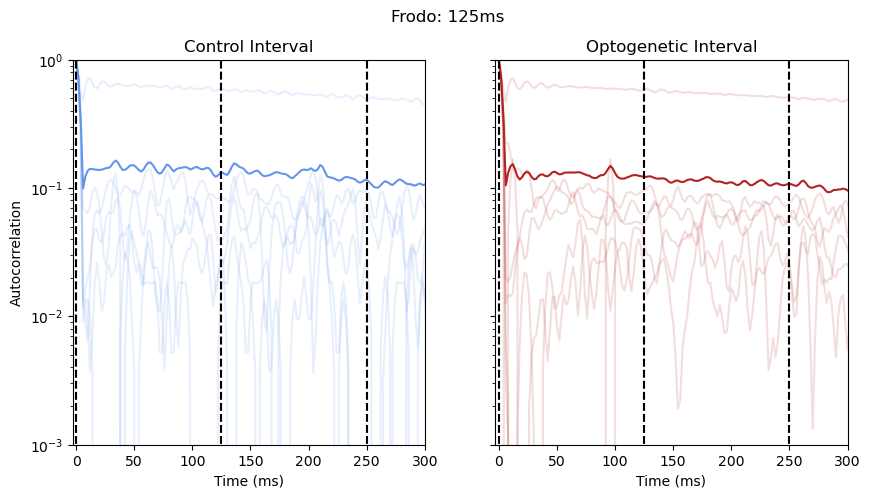

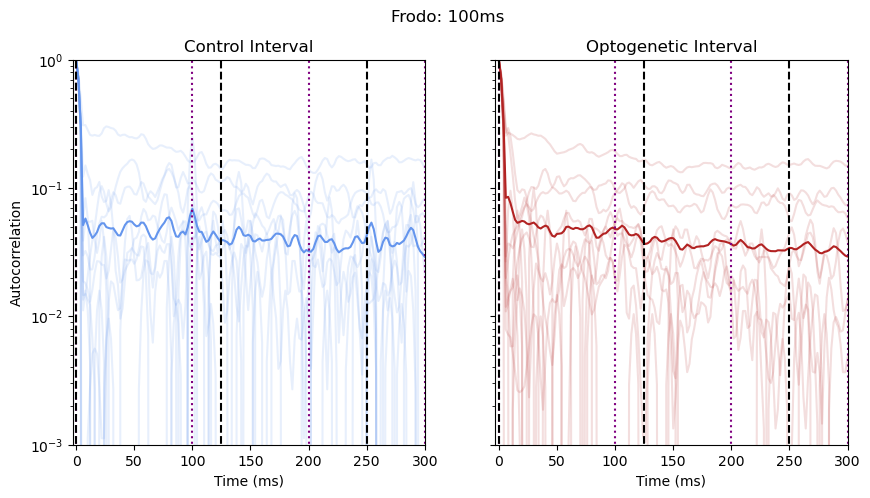

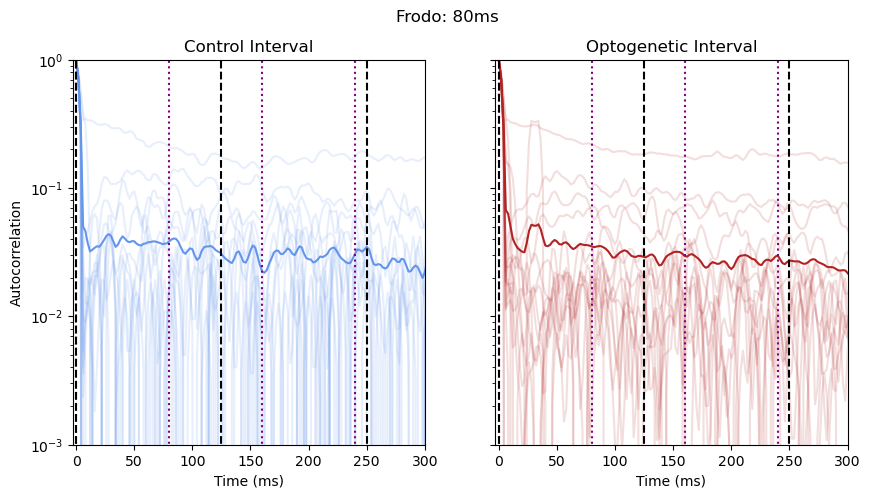

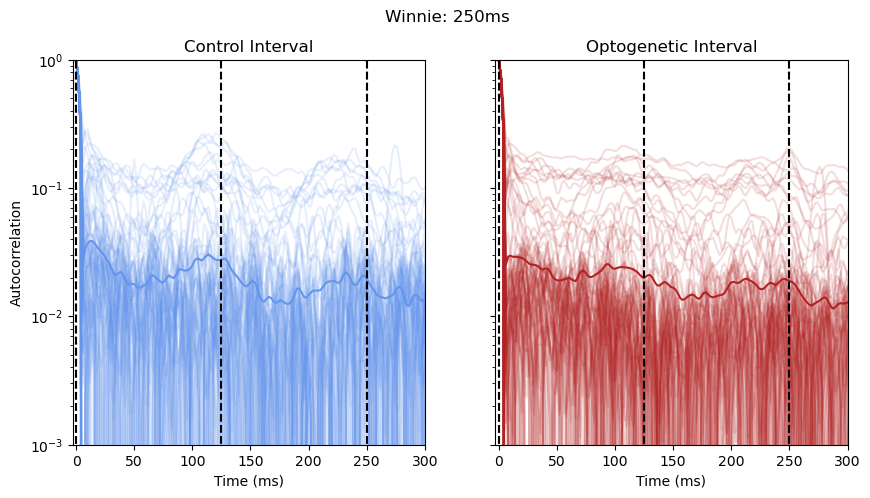

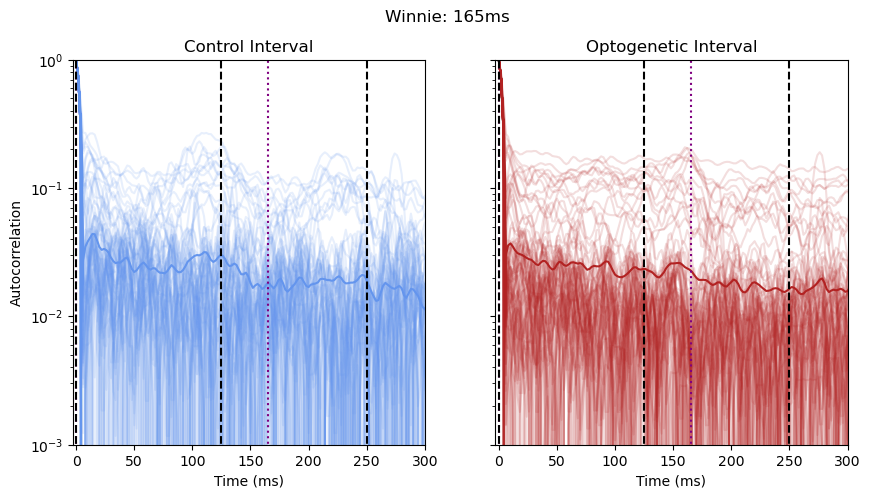

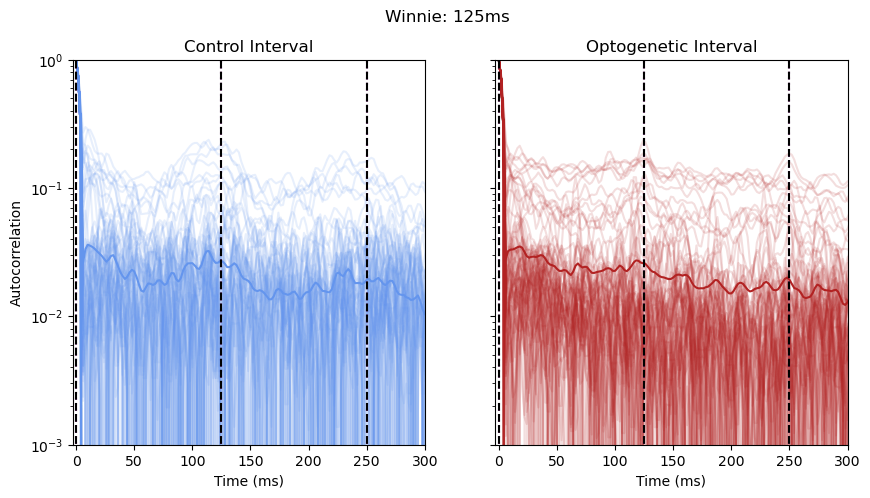

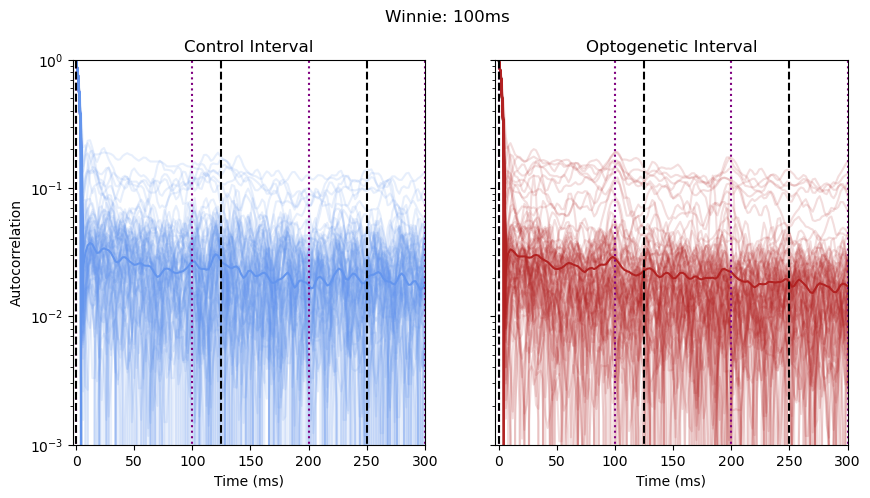

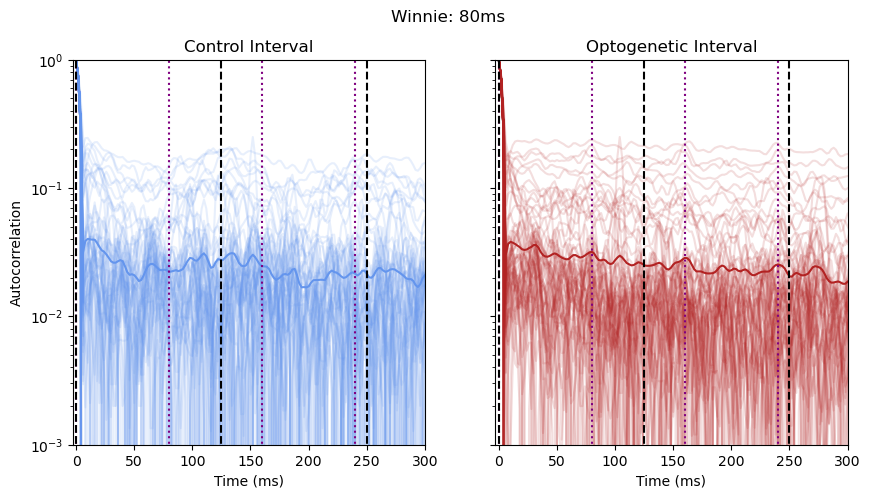

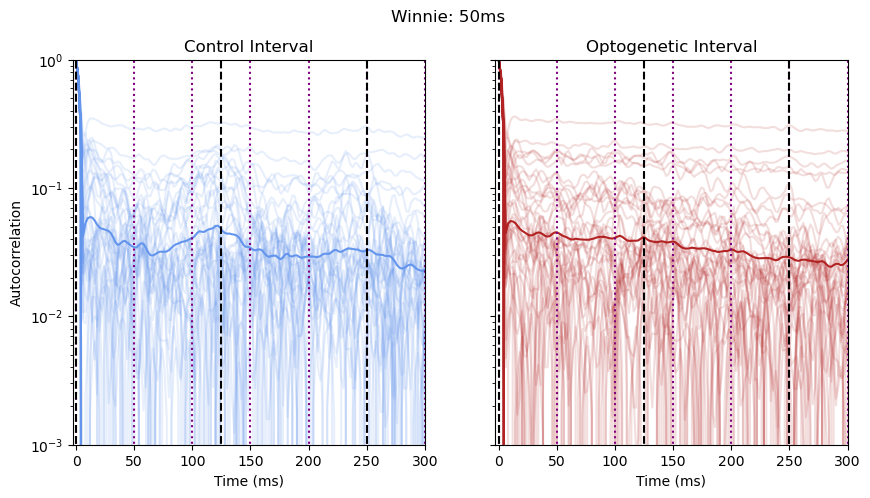

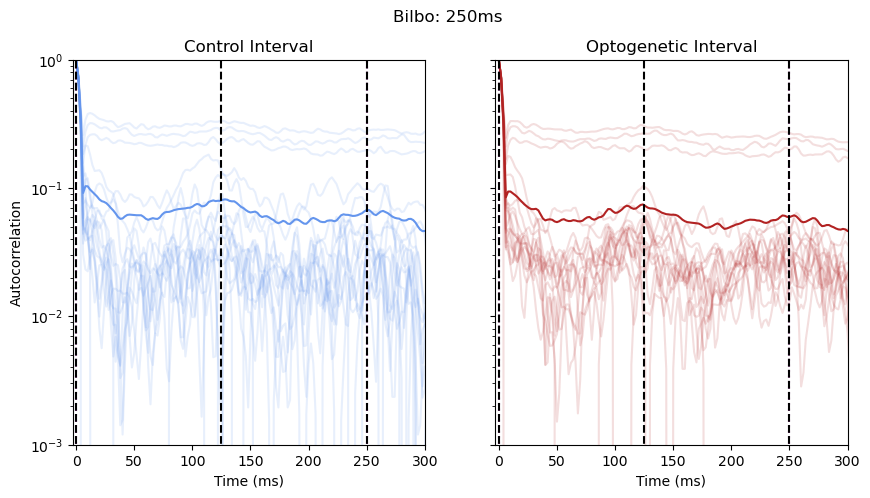

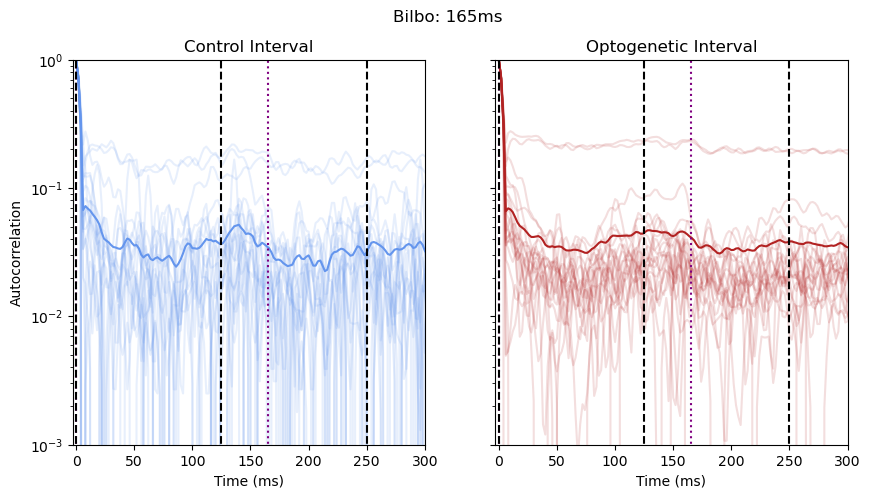

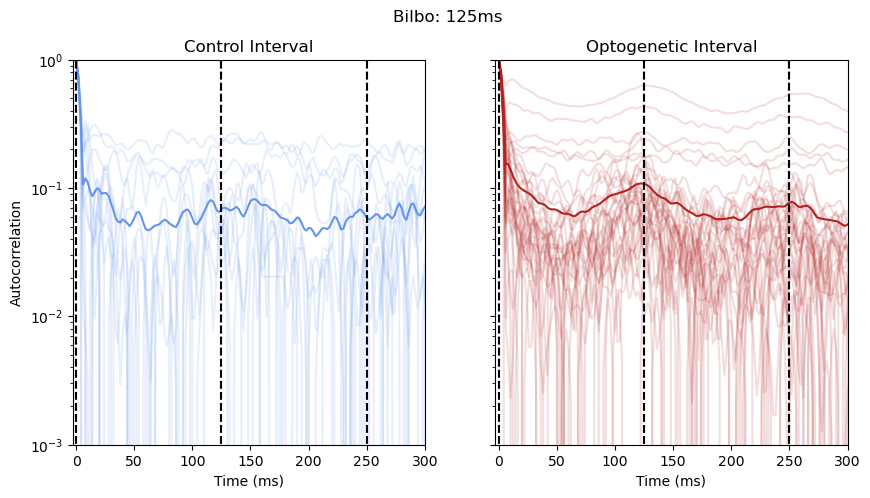

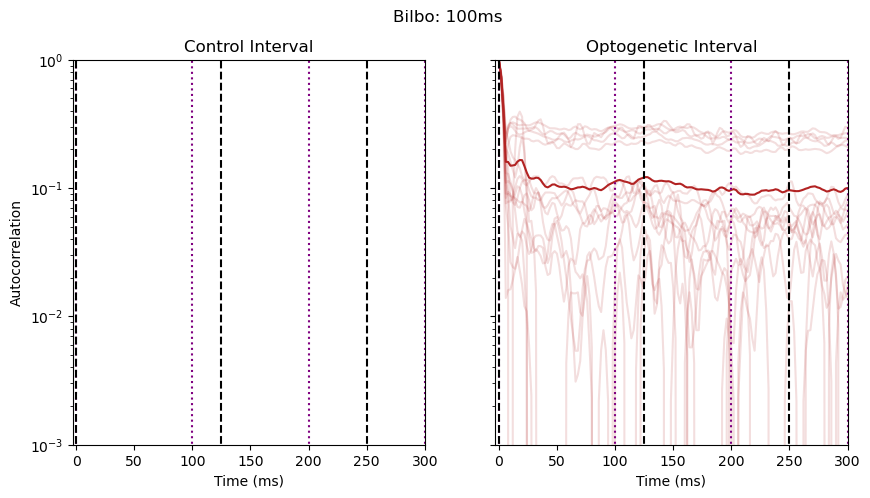

In [54]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from Analysis.spiking_autocorrelation import spiking_autocorrelation

for animal in ['Totoro','Frodo','Winnie','Bilbo']:
    for period in [250,165,125,100,80,50]:
        dataset_key = {'animal':animal,
                    'period_ms': period,
                    'min_pulse_length':20}

        spiking_autocorrelation(dataset_key,filter_speed=4)

In [2]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [3]:
#autocorrelation along the time (second) axis
def autocorr2d(x):
    n = x.shape[0]
    # Zero-pad the array for FFT-based convolution
    padded_x = np.pad(x, ((0, n), (0, 0)), 'constant')
    
    # Compute FFT and its complex conjugate
    X_f = np.fft.fft(padded_x, axis=0)
    result = np.fft.ifft(X_f * np.conj(X_f), axis=0).real

    # Return the positive lags
    return result[:n]

C = autocorr2d(spike_counts.T)




(0.003, 1)

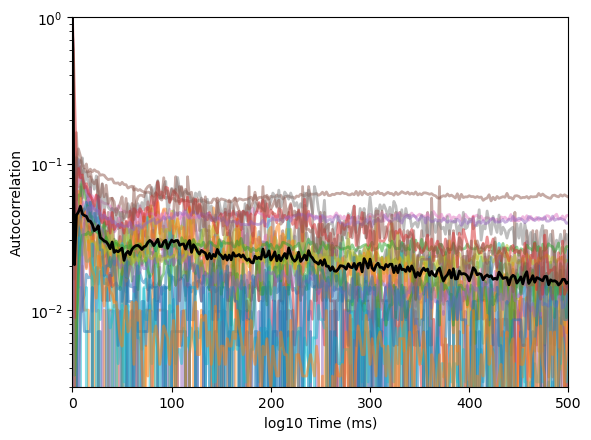

In [8]:

t = np.arange(0,C.shape[0],.002)*1000
# t = np.log10(t)
C_plot = C[:1000]/np.max(C[1:],axis=0)
C_plot = C[:1000]/C[0]
C_avg = np.mean(C_plot,axis=1)
plt.plot(t[:1000],C_plot,lw = 2,alpha=.5)#C[0])
plt.plot(t[:1000],C_avg,lw = 2,color='k')
# plt.xlim(0,3)
plt.xlim(0,500)
# plt.ylim(0,.2)
plt.xlabel('log10 Time (ms)')
plt.ylabel('Autocorrelation')
plt.yscale('log')
plt.ylim(.003,1)
# plt.xscale('log')
# plt.xlim(2,200)

In [6]:
np.min(C)

-8.003260078923207e-13

# OLD VERSION

In [158]:
from spyglass.common import Session
(CuratedSpikeSorting() * Session)&{"subject_id":"Yoshi","sort_group_id":1}
# ((CuratedSpikeSorting() * Session)&{"subject_id":"Olive"}).fetch("sort_interval_name")

*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter        *sorter_params *artifact_remo analysis_file_ units_object_i subject_id     institution_na lab_name       session_id     session_descri session_start_ timestamps_ref experiment_des
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
1              Yoshi20220509_ 1              01_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220509_ Yoshi20220509_                Yoshi          University of  Loren Frank    Yoshi_20220509 Medial Septal  2022-05-09 13: 1970-01-01 00: Medial Septal 
1              Yoshi20220509_ 1              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220509_ Yoshi20220509_ dbcf9134-cedd- Yoshi          University of  Loren Frank    Yoshi_20220509 Medial Septal  2022-05-09 13: 1970-01-01 00: Medial Septal 
1              Yoshi20220509_ 1              15_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220509_ Yoshi20220509_                Yoshi          University of  Loren Frank    Yoshi_20220509 Medial Septal  2022-05-09 13: 1970-01-01 00: Medial Septal 
1              Yoshi20220510_ 1              05_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220510_ Yoshi20220510_                Yoshi          University of  Loren Frank    Yoshi_20220510 Medial Septal  2022-05-10 11: 1970-01-01 00: Medial Septal 
1              Yoshi20220510_ 1              12_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220510_ Yoshi20220510_ 88d8b0ef-9ed8- Yoshi          University of  Loren Frank    Yoshi_20220510 Medial Septal  2022-05-10 11: 1970-01-01 00: Medial Septal 
1              Yoshi20220513_ 1              01_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220513_ Yoshi20220513_ c4cf05b4-0cfc- Yoshi          University of  Loren Frank    Yoshi_20220513 Medial Septal  2022-05-13 10: 1970-01-01 00: Medial Septal 
1              Yoshi20220513_ 1              04_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220513_ Yoshi20220513_                Yoshi          University of  Loren Frank    Yoshi_20220513 Medial Septal  2022-05-13 10: 1970-01-01 00: Medial Septal 
1              Yoshi20220513_ 1              10_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220513_ Yoshi20220513_ b266362c-7da9- Yoshi          University of  Loren Frank    Yoshi_20220513 Medial Septal  2022-05-13 10: 1970-01-01 00: Medial Septal 
1              Yoshi20220513_ 1              15_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220513_ Yoshi20220513_ 74640be4-68a9- Yoshi          University of  Loren Frank    Yoshi_20220513 Medial Septal  2022-05-13 10: 1970-01-01 00: Medial Septal 
1              Yoshi20220516_ 1              14_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220516_ Yoshi20220516_                Yoshi          University of  Loren Frank    Yoshi_20220516 Medial Septal  2022-05-16 11: 1970-01-01 00: Medial Septal 
1              Yoshi20220517_ 1              01_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220517_ Yoshi20220517_                Yoshi          University of  Loren Frank    Yoshi_20220517 Medial Septal  2022-05-17 11: 1970-01-01 00: Medial Septal 
1              Yoshi20220517_ 1              02_wtrack      franklab_tetro ms_stim       mountainsort4  franklab_tetro Yoshi20220517_ Yoshi20220517_                Yoshi          University of  Loren Frank    Yoshi_20220517 Medial Septal  2022-05-17 11: 1970-01-01 00: Medial Septal 
   ...
 (Total: 1003)

## Define Data

In [182]:
nwb_file_name = "Winnie20220714_.nwb"
# nwb_file_name = "Totoro20220602_.nwb"
# nwb_file_name = "Yoshi20220510_.nwb"
interval_name = "06_lineartrack"
interval_name = '15_sleep'
interval_name = '08_lineartrack'
sort_interval_name = interval_name

# nwb_file_name = "Wallie20220911_.nwb"
# nwb_file_name = "Olive20220627_.nwb"
pos_interval_name = convert_epoch_interval_name_to_position_interval_name({"nwb_file_name":nwb_file_name,
                         "interval_list_name":interval_name})

print(interval_name), print(pos_interval_name)

08_lineartrack
pos 7 valid times


(None, None)

## Get Data

In [177]:
from spyglass.common import ElectrodeGroup, Electrode

ElectrodeGroup & {"nwb_file_name":nwb_file_name}

Electrode & {"nwb_file_name":nwb_file_name}

*nwb_file_name *electrode_gro *electrode_id  probe_id       probe_shank    probe_electrod region_id     name     original_refer x       y       z       filtering     impedance     bad_channel    x_warped     y_warped     z_warped     contacts    
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------+ +------------+ +-----+ +-----+ +-----+ +-----------+ +-----------+ +------------+ +----------+ +----------+ +----------+ +----------+
Winnie20220714 0              0              tetrode_12.5   0              0              16            0        12             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
Winnie20220714 0              1              tetrode_12.5   0              1              16            1        12             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
Winnie20220714 0              2              tetrode_12.5   0              2              16            2        12             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
Winnie20220714 0              3              tetrode_12.5   0              3              16            3        12             0.0     0.0     0.0     None          0.0           True           0.0          0.0          0.0                      
Winnie20220714 1              4              tetrode_12.5   0              0              16            4        12             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
Winnie20220714 1              5              tetrode_12.5   0              1              16            5        12             0.0     0.0     0.0     None          0.0           True           0.0          0.0          0.0                      
Winnie20220714 1              6              tetrode_12.5   0              2              16            6        12             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
Winnie20220714 1              7              tetrode_12.5   0              3              16            7        12             0.0     0.0     0.0     None          0.0           False          0.0          0.0          0.0                      
Winnie20220714 10             40             tetrode_12.5   0              0              16            40       12             0.0     0.0     0.0     None          0.0           True           0.0          0.0          0.0                      
Winnie20220714 10             41             tetrode_12.5   0              1              16            41       12             0.0     0.0     0.0     None          0.0           True           0.0          0.0          0.0                      
Winnie20220714 10             42             tetrode_12.5   0              2              16            42       12             0.0     0.0     0.0     None          0.0           True           0.0          0.0          0.0                      
Winnie20220714 10             43             tetrode_12.5   0              3              16            43       12             0.0     0.0     0.0     None          0.0           True           0.0          0.0          0.0                      
   ...
 (Total: 128)

In [171]:
set((CuratedSpikeSorting() & {"nwb_file_name":nwb_file_name}).fetch("sort_interval_name"))
# sort
CuratedSpikeSorting() & {"nwb_file_name":nwb_file_name,}# "sort_interval_name":sort_interval_name}

*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter        *sorter_params *artifact_remo analysis_file_ units_object_i
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+
1              Winnie20220714 0              01_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 321adcd9-0f6c-
1              Winnie20220714 0              07_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 9ecbeea5-f2df-
1              Winnie20220714 0              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 e06e2875-e1d6-
1              Winnie20220714 0              15_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 acadcde7-26ab-
1              Winnie20220714 1              01_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 e31edae3-9691-
1              Winnie20220714 1              07_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 62f6c0b1-b52b-
1              Winnie20220714 1              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 4eaecbbe-6df9-
1              Winnie20220714 1              15_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 92a0d156-1ae3-
1              Winnie20220714 2              01_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 d9f318aa-789f-
1              Winnie20220714 2              07_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 85bc0240-0e68-
1              Winnie20220714 2              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 1fec4fec-a9ca-
1              Winnie20220714 2              15_sleep       franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 75879ffb-cd20-
   ...
 (Total: 108)

In [185]:
CuratedSpikeSorting() & basic_key& {"curation_id":cur_id} 

*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter        *sorter_params *artifact_remo analysis_file_ units_object_i
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+
2              Winnie20220714 0              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 2e60551d-28a1-
2              Winnie20220714 1              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 c75733d4-f71d-
2              Winnie20220714 2              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 c704dde9-3a18-
2              Winnie20220714 3              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 4cf8f333-8f99-
2              Winnie20220714 4              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 37ed9ccf-bd92-
2              Winnie20220714 5              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714               
2              Winnie20220714 6              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714               
2              Winnie20220714 7              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 f1063065-3aeb-
2              Winnie20220714 8              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 ad6fa14b-d6a8-
2              Winnie20220714 9              08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 23e0b88c-a9ca-
2              Winnie20220714 10             08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714 181141d6-a5ae-
2              Winnie20220714 11             08_lineartrack franklab_tetro ms_stim       mountainsort4  franklab_tetro Winnie20220714 Winnie20220714               
   ...
 (Total: 27)

In [186]:
basic_key = {"nwb_file_name":nwb_file_name, "sort_interval_name":sort_interval_name}
pos_key =  {"nwb_file_name":nwb_file_name,"interval_list_name":pos_interval_name}

restrict_interval = None
# restrict_interval = (OptoStimProtocol() & pos_key).fetch1("test_intervals")
# restrict_interval = (OptoStimProtocol() & pos_key).fetch1("control_intervals")
restrict_interval_list = [(OptoStimProtocol() & pos_key).fetch1("control_intervals"),
                     (OptoStimProtocol() & pos_key).fetch1("test_intervals"),]

spike_df = []
cur_id = 1#np.max((CuratedSpikeSorting() & basic_key).fetch("curation_id"))
print(cur_id)
for key in (CuratedSpikeSorting() & basic_key& {"curation_id":cur_id} & {"sort_group_id":27}):
    tetrode_df = ((CuratedSpikeSorting & key).fetch_nwb()[0])
    if 'units' in tetrode_df:
        tetrode_df = tetrode_df['units']
        tetrode_df = tetrode_df[tetrode_df.label == ""]
        spike_df.append(tetrode_df)
        if len(tetrode_df) >4:
            break
        # break
spike_df = pd.concat(spike_df)

1


In [187]:
tetrode_df = ((CuratedSpikeSorting & key).fetch_nwb()[0])
# type(tetrode_df)
tetrode_df = tetrode_df['units']
tetrode_df = tetrode_df[tetrode_df.label == ""]

tetrode_df
CuratedSpikeSorting() & basic_key & {"curation_id":cur_id}
CurationFigurl & basic_key & {"sort_group_id":key['sort_group_id']} #& "curation_id=40"
cur_id = np.max((CurationFigurl & basic_key & {"sort_group_id":key['sort_group_id']}).fetch("curation_id"))
print((CurationFigurl & basic_key & {"sort_group_id":key['sort_group_id']} & {"curation_id":cur_id}).fetch("url")[0])
key

ValueError: zero-size array to reduction operation maximum which has no identity

In [188]:
def get_spikecount_per_time_bin(spike_times, time):
    spike_times = spike_times[
        np.logical_and(spike_times >= time[0], spike_times <= time[-1])
    ]
    return np.bincount(
        np.digitize(spike_times, time[1:-1]),
        minlength=time.shape[0],
    )

place_fields = []
epoch_time = np.arange(np.min([np.min(x) for x in restrict_interval_list]),
                       np.max([np.max(x) for x in restrict_interval_list]),
                        0.002)
spike_counts = np.zeros((epoch_time.shape[0], spike_df.shape[0]))
for i,spike_times in enumerate(spike_df.spike_times):
    spike_counts[:, i] = get_spikecount_per_time_bin(spike_times, epoch_time)
ind_keep = np.where(np.sum(spike_counts, axis=0)>1000)[0]
spike_counts = spike_counts[:,ind_keep]

In [189]:
def autocorr2d(x):
    n = x.shape[0]
    # Zero-pad the array for FFT-based convolution
    padded_x = np.pad(x, ((0, n), (0, 0)), 'constant')
    
    # Compute FFT and its complex conjugate
    X_f = np.fft.fft(padded_x, axis=0)
    result = np.fft.ifft(X_f * np.conj(X_f), axis=0).real

    # Return the positive lags
    return result[:n]

C = [[],[]]

for interval in restrict_interval_list[0]:
    C[0].append(autocorr2d(spike_counts[interval_list_contains_ind([interval],epoch_time,)]))
for interval in restrict_interval_list[1]:
    C[1].append(autocorr2d(spike_counts[interval_list_contains_ind([interval],epoch_time,)]))


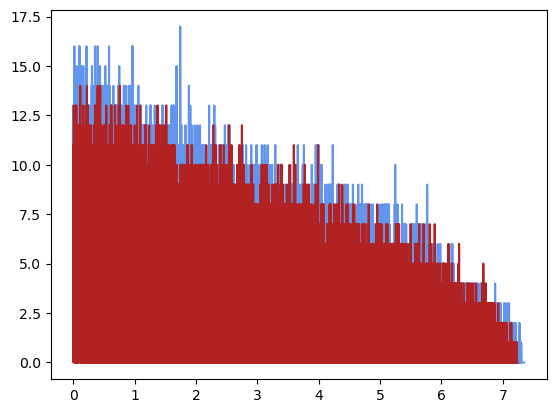

In [190]:
import matplotlib.pyplot as plt

c = C[0][0]
c_x = np.arange(0, c.shape[0], 1)*0.002/60#*1000
plt.plot(c_x[1:],c[1:],c='cornflowerblue')

c = C[1][0]
c_x = np.arange(0, c.shape[0], 1)*0.002/60#*1000
plt.plot(c_x[1:],c[1:],c='firebrick')
# plt.xlim(0,300000)
# plt.xlim(0,.1)

In [76]:
# (OptoStimProtocol() & pos_key).fetch1("period_ms")
from spyglass.spikesorting import CurationFigurl

print((CurationFigurl  & basic_key).fetch("url")[2])
# pos_key
# CuratedSpikeSorting() & basic_key

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://4fa8f189442f50fa652399a8832f58a57a177e2d&s={"initialSortingCuration":"sha1://6d9627753d28335c9e652b012e3f673c264f6195","sortingCuration":"gh://LorenFrankLab/sorting-curations/main/sambray/Olive20220627_.nwb_04_lineartrack_entire/2/curation.json"}&label=Olive20220627_.nwb_04_lineartrack_2_franklab_tetrode_hippocampus%20Olive20220627_.nwb_04_lineartrack_2_franklab_tetrode_hippocampus_d8a43a06_spikesorting


IndexError: index 1 is out of bounds for axis 1 with size 1

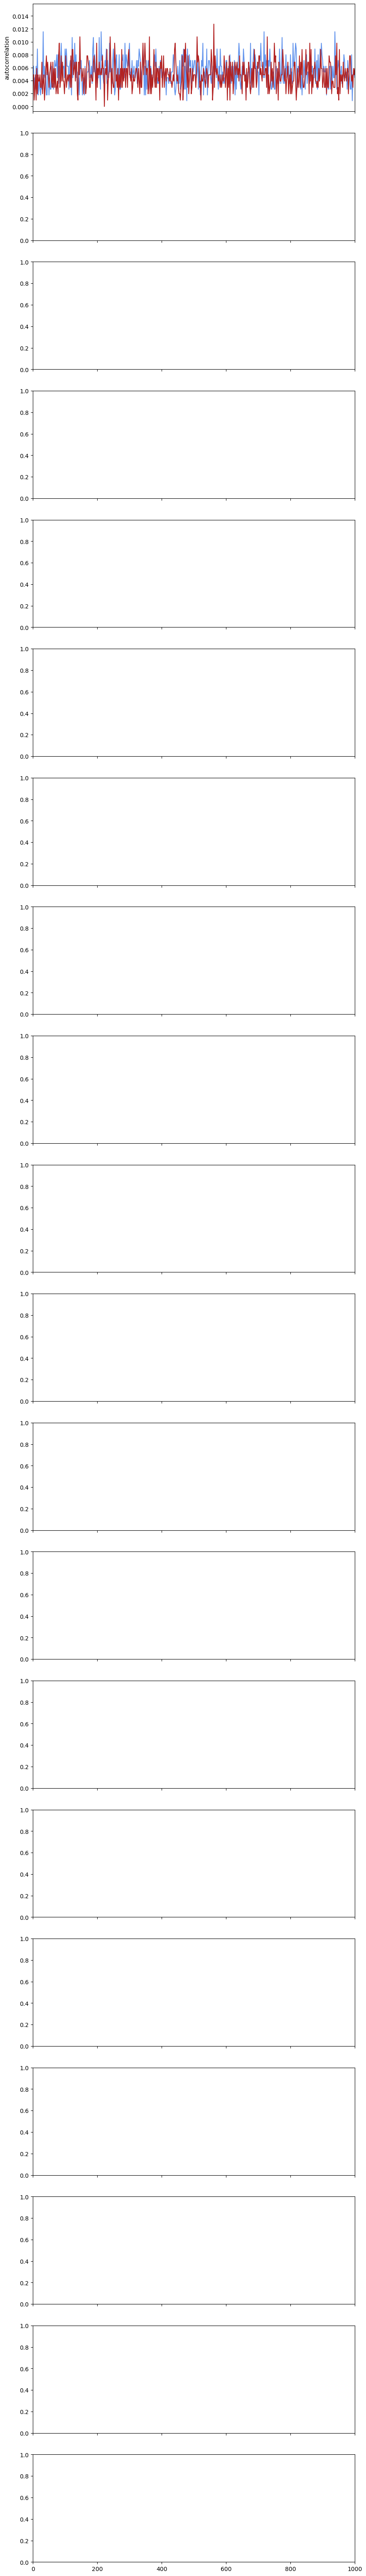

In [191]:
n=20
fig, ax = plt.subplots(nrows=n,figsize=(10,n*4),sharex=True)

for i,a in enumerate(ax):
    c = C[0][0]
    c_x = np.arange(0, c.shape[0], 1)*0.002*1000
    a.plot(c_x[1:],c[1:,i]/c[0,i],c='cornflowerblue',zorder=2)

    c = C[1][0]
    c_x = np.arange(0, c.shape[0], 1)*0.002*1000
    a.plot(c_x[1:],c[1:,i]/c[0,i],c='firebrick')
    a.set_xlim(0,1000)
    a.set_ylabel('autocorrelation')
ax[-1].set_xlabel('lag time (ms)')


    

In [73]:
C[0][0].shape

(167153, 184)

In [74]:
C[1][0].shape

(225742, 184)